In [2]:
import pandas as pd
import duckdb
import geopy
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
db_path = '../data/RE_moscow_db.duckdb'
geodata_path = 'geo_cache/moscow.graphml'

In [13]:
with duckdb.connect(db_path) as w:
    df = w.execute('select * from builder_ads').df()
city_graph = ox.load_graphml(geodata_path)
gp = geopy.Nominatim(user_agent='geo_features',timeout=1.44)

In [5]:
moscow_center = gp.geocode('Москва')
print(moscow_center)

Москва, Центральный федеральный округ, Россия


In [18]:
rng_adress = df['adress'].sample(1).iloc[0]
test_point = gp.geocode(f'{rng_adress}')
print(test_point)

Дмитровское шоссе, район Лианозово, район Северный, Москва, Центральный федеральный округ, 127253, Россия


In [19]:
def get_path_data(city_graph,start_point,end_point):

    start_node = ox.nearest_nodes(city_graph, start_point.longitude,start_point.latitude)
    end_node = ox.nearest_nodes(city_graph, end_point.longitude,end_point.latitude)

    shortest_route = nx.shortest_path(city_graph,
                                    start_node,
                                    end_node,
                                    weight='length')
    path_length = 0
    start_micropath = shortest_route[0]
    for end_micropath in shortest_route[1:]:
        path_length+=city_graph[start_micropath][end_micropath][0]['length']
        start_micropath = end_micropath

    distance_to_center = ox.distance.great_circle_vec(start_point.latitude,start_point.longitude,
                                                        end_point.latitude,end_point.longitude,)
                                                                                  
    fig, ax = ox.plot_graph_route(city_graph, shortest_route, orig_dest_size=0, node_size=0)

    path_data_dict = {
        'long':start_point.longitude,
        'lat':start_point.latitude,
        'distance_from_center':distance_to_center,
        'route_to_center':path_length,
        'time_to_center': path_length / 1000 / 60 * 60 * 1.5,
        'route_img':fig
    }
    return path_data_dict

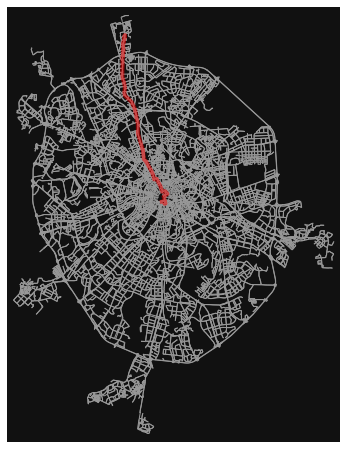

In [20]:
some_obj = get_path_data(city_graph,test_point.point,moscow_center.point)

In [21]:
some_obj

{'long': 37.5437272,
 'lat': 55.9076576,
 'distance_from_center': 18078.03795731073,
 'route_to_center': 26120.200000000004,
 'time_to_center': 39.1803,
 'route_img': <Figure size 576x576 with 1 Axes>}

In [ ]:
def get_geodata_features(adresses:list,geoagent,city_graph):
    moscow_center = geoagent.geocode('Москва')
    geo_map = {}
    for adress in adresses:
        geopoint = geoagent.geocode(adress)
        geo_map[adress] = get_path_data(city_graph,geopoint.point,moscow_center.point)